In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ds = xr.load_dataset('../../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly.nc')

In [3]:
lat_bounds = slice(44.75, 46.65)
lon_bounds = slice(8.5, 11.25)

agl = ds.agl.sel(lat=lat_bounds, lon=lon_bounds)

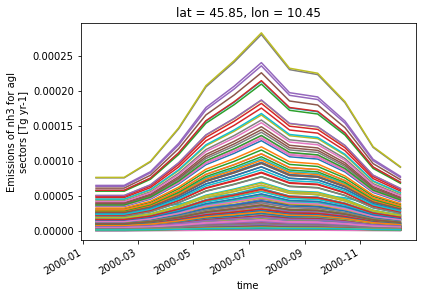

In [4]:
plt.figure()
for i in range(12):
    for j in range(20):
        agl[:, i, j][0:12].plot()

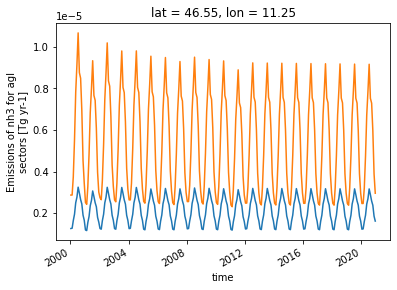

In [5]:
plt.figure()
agl[:, 0, 0].plot()
agl[:, -1, -1].plot()

<AxesSubplot:>

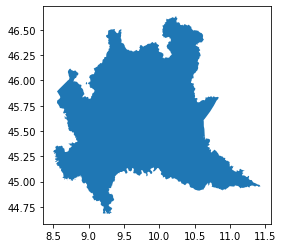

In [6]:
import geopandas as gpd
from shapely.geometry import Point

import geopandas as gpd
from shapely.geometry import Point

df = gpd.read_file('../../resources/regione/regione_2015.shp')

df.to_crs(epsg=4326, inplace=True)
df.plot()

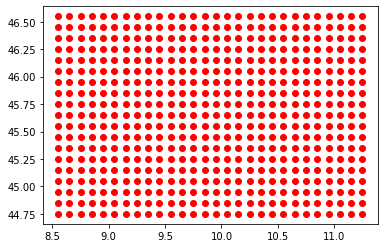

In [7]:
lats = agl.lat
lons = agl.lon

coords = [(lat, lon) for lat in lats.to_series() for lon in lons.to_series().tolist()]

lats = [coord[0] for coord in coords]
lons = [coord[1] for coord in coords]

plt.scatter(lons, lats, c='r')


In [8]:
grid = [ (round(lat, 2), round(lon, 2)) for lat, lon in zip(lats, lons) if df.geometry.contains(Point(lon, lat)).bool()]

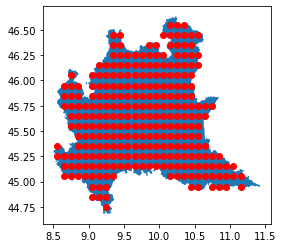

In [9]:
lats = [coord[0] for coord in grid]
lons = [coord[1] for coord in grid]

df.plot()
plt.scatter(lons, lats, c='r')

plt.show()

In [10]:
agl_lats = [round(lat, 2) for lat in agl.lat.to_series().tolist()]
agl_lons = [round(lon, 2) for lon in agl.lon.to_series().tolist()]

data = np.zeros((len(agl_lats), len(agl_lons)))
data.fill(np.nan)

for lat_idx, lat in enumerate(agl_lats):
    for lon_idx, lon in enumerate(agl_lons):
        if (lat, lon) in grid:
            data[lat_idx][lon_idx] = np.mean(agl[:12, lat_idx, lon_idx].to_series().tolist())

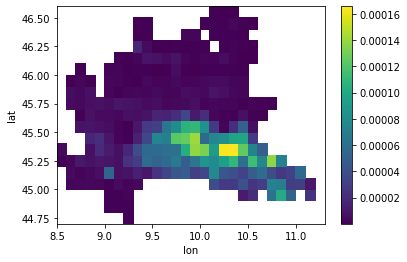

In [11]:
mean_agl = xr.DataArray(data, coords=[agl_lats, agl_lons], dims=['lat', 'lon'])
mean_agl.plot()

In [12]:
ts_data = np.ones((252, len(agl_lats), len(agl_lons)))
ts_data.fill(np.nan)

for lat_idx, lat in enumerate(agl_lats):
    for lon_idx, lon in enumerate(agl_lons):
        if (lat, lon) in grid:
            for time_idx in range(len(agl.time.to_series().tolist())):
                ts_data[time_idx][lat_idx][lon_idx] = agl[time_idx, lat_idx, lon_idx].values

In [13]:
times = agl.time.to_series().tolist()

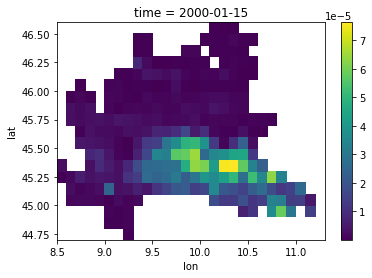

In [14]:
lombardia_ts = xr.DataArray(ts_data, coords=[times, agl_lats, agl_lons], dims=['time', 'lat', 'lon'])
lombardia_ts[0, :, :].plot()

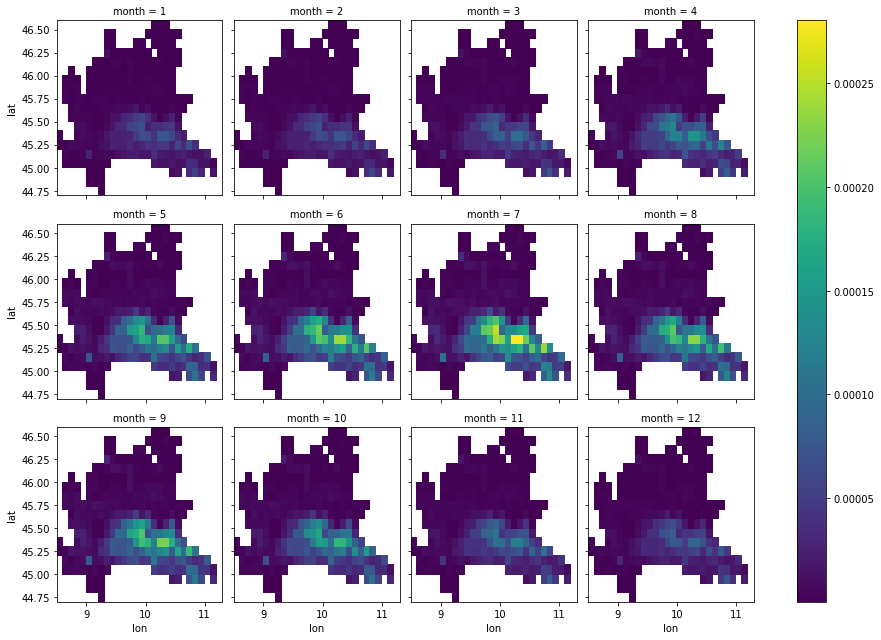

In [15]:
lombardia_ts.groupby('time.month').mean().plot(col='month', col_wrap=4)

In [16]:
max_coords = lombardia_ts.mean(dim='time').argmax(dim=['lat', 'lon'])
max_lat = max_coords['lat'].values
max_lon = max_coords['lon'].values

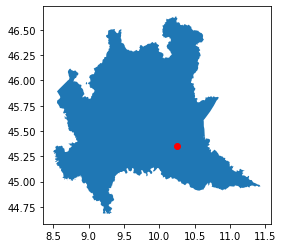

In [17]:
df.plot()
plt.scatter(agl_lons[max_lon], agl_lats[max_lat], c='r')
plt.show()

In [18]:
max_ts = lombardia_ts[:, max_lat, max_lon]

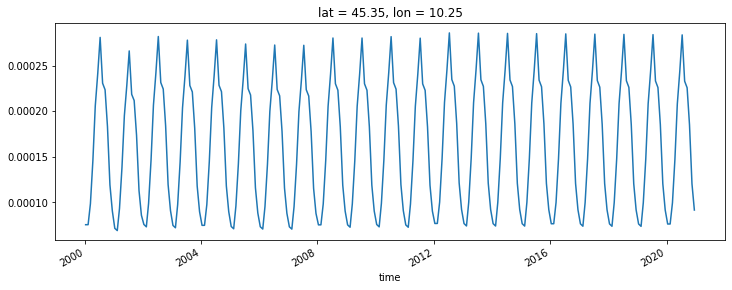

In [19]:
plt.figure(figsize=(12, 4))
max_ts.plot()

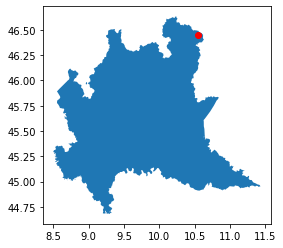

In [20]:
min_coords = lombardia_ts.mean(dim='time').argmin(dim=['lat', 'lon'])
min_lat = min_coords['lat'].values
min_lon = min_coords['lon'].values

df.plot()
plt.scatter(agl_lons[min_lon], agl_lats[min_lat], c='r')
plt.show()

In [21]:
min_ts = lombardia_ts[:, min_lat, min_lon]

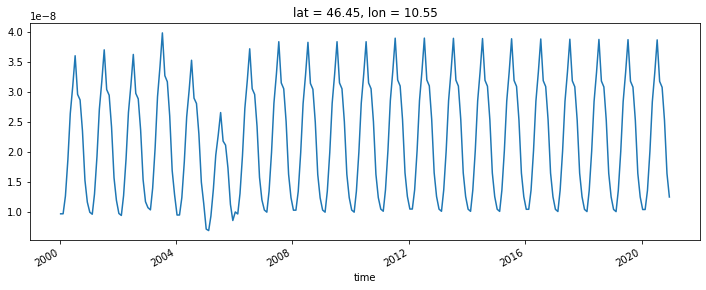

In [22]:
plt.figure(figsize=(12, 4))
min_ts.plot()

In [23]:
mean_values = lombardia_ts.mean(dim='time')
mean_value = np.mean(mean_values)
epsilon = 1e-5

mean_coords = []

for lat_idx, lat in enumerate(mean_values.lat.to_series().tolist()):
    for lon_idx, lon in enumerate(mean_values.lat.to_series().tolist()):
        if not np.isnan(mean_values[lat_idx, lon_idx]):
            # print('value: {} mean: {}'.format(float(mean_values[lat_idx, lon_idx].values), float(mean_value)))
            # print(float(mean_values[lat_idx, lon_idx].values) - float(mean_value) )
            if np.absolute(float(mean_values[lat_idx, lon_idx].values) - float(mean_value)) < epsilon:
                mean_coords = (lat_idx, lon_idx)
                break
mean_coords

(15, 8)

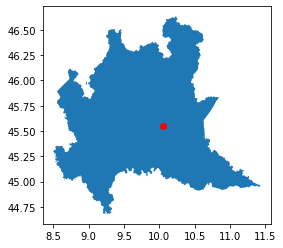

In [24]:
df.plot()
plt.scatter(agl_lons[mean_coords[0]], agl_lats[mean_coords[1]], c='r')
plt.show()

In [25]:
mean_ts = lombardia_ts[:, mean_coords[0], mean_coords[1]]

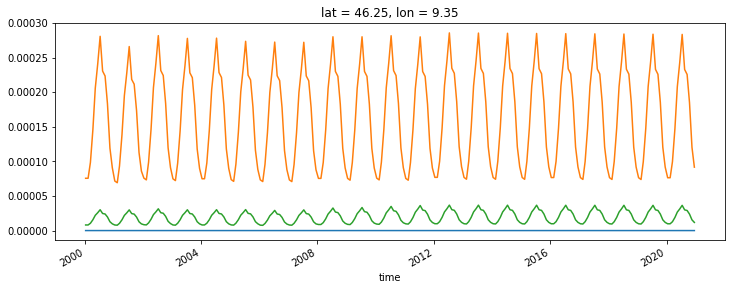

In [26]:
plt.figure(figsize=(12, 4))
min_ts.plot()
max_ts.plot()
mean_ts.plot()

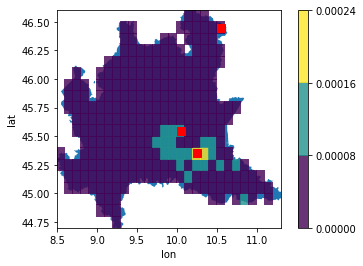

In [27]:
df.plot()
mean_values.plot(alpha=0.8, levels=3)
plt.plot(agl_lons[mean_coords[0]], agl_lats[mean_coords[1]], 'rs', ms=8)
plt.plot(agl_lons[min_lon], agl_lats[min_lat], 'rs', ms=8)
plt.plot(agl_lons[max_lon], agl_lats[max_lat], 'rs', ms=8)
plt.show()

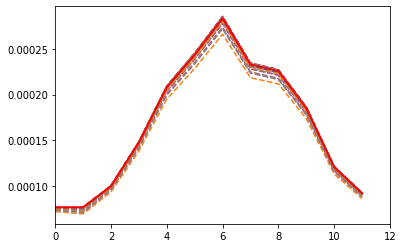

In [28]:
agl_ts = agl[:, max_lat, max_lon]
ts_b4_lockdown = agl_ts[:240]
ts_after_lockdown = agl_ts[240:252]
plt.figure()
plt.xlim([0, 12])
for i in range(18):
    plt.plot(ts_b4_lockdown.values[12*i:(i+1)*12], '--')
plt.plot(ts_after_lockdown.values[:], 'r-', linewidth=2)